In [1]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable
from pfd import PFD
from nco import NCO
fs = np.uint32(12288e4)

In [2]:
def nco_gen(initial_phase: float = 0,
            lut_size: int        = 2**14,
            phase_acc_width: int = 24) -> Callable[[np.uint32], np.uint16]:

  msk = (2 ** phase_acc_width) - 1
  phase_acc_val = np.uint32(initial_phase * (2 ** phase_acc_width))

  def nco(step: np.uint32) -> np.uint16:
    nonlocal phase_acc_val

    # output the index (higher 14 bits) of a waveform lut
    output        = (phase_acc_val & msk) >> 10
    # next acc value
    phase_acc_val = ((phase_acc_val & msk) + (step & msk)) & msk

    return output

  return nco

def dff_gen()-> Callable[[bool, bool, bool], bool]:
  prev_out: bool = False
  prev_clk: bool = False

  def dff(input: bool, clear :bool, clk: bool) -> bool:
    nonlocal prev_out
    nonlocal prev_clk
    if clk and (not prev_clk):
      output   = 0 if clear else input
      prev_out = output
      prev_clk = clk
      return output

    prev_clk = clk
    prev_out = 0 if clear else prev_out
    return prev_out

  return dff

def lpf1_gen():
  prev_out: np.int16 = 0 # s1q14

  def lpf(input: np.int8) -> np.int16:
    nonlocal prev_out
    # only accept +/-1 (+/- 1/64 under s1q14) or 0 as input
    if input > 0:
      input = 256
    elif input < 0:
      input = -256
    else:
      input = 0

    # (y[n] = 31/32 * y[n-1] + 1/32 x[n])
    if prev_out >= 0:
      output = (prev_out - (prev_out >> 6)) + input
    else:
      prev_out *= -1
      output = input - (prev_out - (prev_out >> 6))

    prev_out = output
    return output
  return lpf

def pfd_gen():
  dff_a = dff_gen()
  dff_b = dff_gen()
  prev_clear: bool = False

  def pfd(a: bool, b: bool) -> np.int16:
    nonlocal dff_a
    nonlocal dff_b
    nonlocal prev_clear

    out_a = dff_a(True, prev_clear, a)
    out_b = dff_b(True, prev_clear, b)

    prev_clear = out_a and out_b

    out_a = 1  if out_a else 0
    out_b = -1 if out_b else 0

    output = out_a + out_b
    return output

  return pfd

def acc_gen():
  acc_val: np.int32 = 0

  def acc(input: np.int8) -> np.int32:
    nonlocal acc_val
    output = acc_val + np.int32(input)
    acc_val = output
    return acc_val
  return acc

def mav_gen(width = 32):
  fifo = [0 for i in range(width-1)]
  def mav(input: np.int16):
    nonlocal fifo
    fifo.append(input)
    output = np.mean(fifo)
    fifo = fifo[1:]
    return output
  return mav

def div2_gen():
  dff = dff_gen()
  n_prev_out: bool = True
  def div2(input: bool) -> bool:
    nonlocal n_prev_out
    output = dff(n_prev_out, False, input)
    n_prev_out = not output
    return output
  return div2

def pll_gen():
  base_step = np.uint32(2**20) # base frequency = fs/16
  msk = (2 ** 24) - 1

  ctrl: np.int32 = 0
  nco = nco_gen()
  pfd  = pfd_gen()
  acc  = acc_gen()
  div2 = div2_gen()

  def pll(input: np.uint16) -> np.uint16:
    '''
    input 16 bits waveform
    return 14 bits indix of the waveform lut
    '''
    nonlocal ctrl
    nonlocal nco
    nonlocal pfd
    nonlocal acc
    nonlocal div2

    output: np.uint32  = nco(base_step + ctrl)
    output_b: bool     = (output & (2**13)) >> 13
    output_b_div2:bool = div2(output_b)
    input_b : bool     = (input & 2**15) >> 15
    pfd_out: np.int8   = pfd(input_b, output_b_div2)
    acc_out: np.int32  = acc(pfd_out)
    ctrl = (np.int32(pfd_out) << 16) + (acc_out << 10)

    return output

  return pll



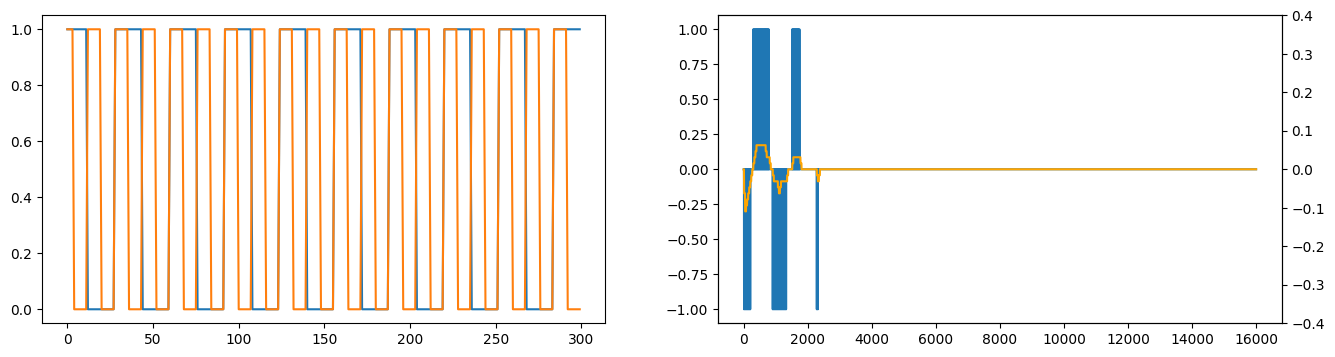

In [3]:
nco1 = nco_gen(initial_phase=0.15)
nco2 = nco_gen()
pfd  = pfd_gen()
acc  = acc_gen()
mav  = mav_gen(64)
div2 = div2_gen()

n_samples = 16*1000

trace_nco1 = np.zeros(n_samples)
trace_nco2 = np.zeros(n_samples)
trace_nco2_div2 = np.zeros(n_samples)
trace_pfd  = np.zeros(n_samples, dtype=np.int32)
trace_acc  = np.zeros(n_samples, dtype=np.int32)
trace_pfd2  = np.zeros(n_samples, dtype=np.float32)

for i in range(n_samples):
  if i == 0:
    pfd_fb = 0
  else:
    pfd_fb = (trace_pfd[i-1] << 16) + (trace_acc[i-1] << 10)
  trace_nco1[i] = (nco1(2**19) & (2**13)) >> 13
  trace_nco2[i] = (nco2(2**20 + pfd_fb) & (2**13)) >> 13
  trace_nco2_div2[i] = div2(trace_nco2[i])
  trace_pfd[i]  = pfd(trace_nco1[i], trace_nco2_div2[i])
  trace_pfd2[i]  = mav(trace_pfd[i])
  trace_acc[i]  = acc(trace_pfd[i])

plt.figure(figsize=(16, 4))

plt.subplot(1, 2, 1)
plt.plot(trace_nco1[10000:10300])
plt.plot(trace_nco2[10000:10300])

ax1 = plt.subplot(1, 2, 2)
ax2 = ax1.twinx()
ax1.plot(trace_pfd)

ax2.plot(trace_pfd2, color="orange")

_ = ax2.set_ylim([-0.4, 0.4])

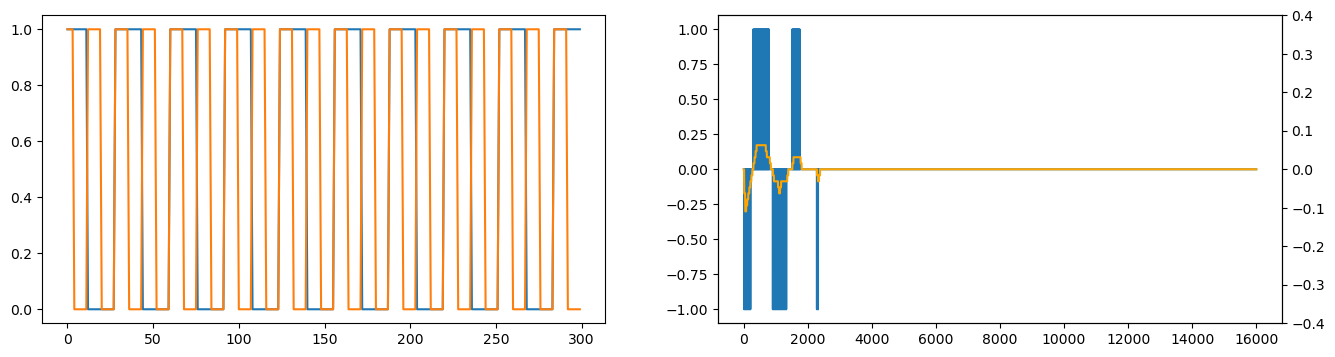

In [4]:
nco1 = nco_gen(initial_phase=0.15)
nco2 = NCO("../../build/exec/nco", silent=True)
pfd_impl  = PFD("../../build/exec/pfd", silent=True)
acc  = acc_gen()
mav  = mav_gen(64)
div2 = div2_gen()

n_samples = 16*1000

trace_nco1 = np.zeros(n_samples)
trace_nco2 = np.zeros(n_samples)
trace_nco2_div2 = np.zeros(n_samples)
trace_pfd  = np.zeros(n_samples, dtype=np.int32)
trace_acc  = np.zeros(n_samples, dtype=np.int32)
trace_pfd2  = np.zeros(n_samples, dtype=np.float32)

try:
    for i in range(n_samples):
      if i == 0:
        pfd_fb = 0
      else:
        pfd_fb           = (trace_pfd[i-1] << 16) + (trace_acc[i-1] << 10)
      trace_nco1[i]      = (nco1(2**19) & (2**13)) >> 13
      trace_nco2[i]      = (nco2.forward(2**20 + pfd_fb) & (2**13)) >> 13
      trace_nco2_div2[i] = div2(trace_nco2[i])
      trace_pfd[i]       = pfd_impl.forward(trace_nco1[i], trace_nco2_div2[i])
      trace_pfd2[i]      = mav(trace_pfd[i])
      trace_acc[i]       = acc(trace_pfd[i])
    
    plt.figure(figsize=(16, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(trace_nco1[10000:10300])
    plt.plot(trace_nco2[10000:10300])
    
    ax1 = plt.subplot(1, 2, 2)
    ax2 = ax1.twinx()
    ax1.plot(trace_pfd)
    
    ax2.plot(trace_pfd2, color="orange")
    
    _ = ax2.set_ylim([-0.4, 0.4])
finally:
    pfd_impl.terminate()

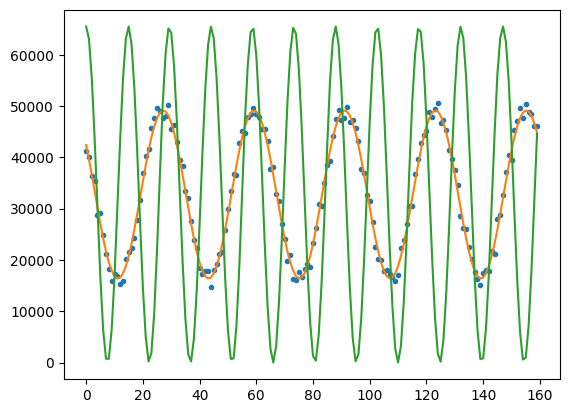

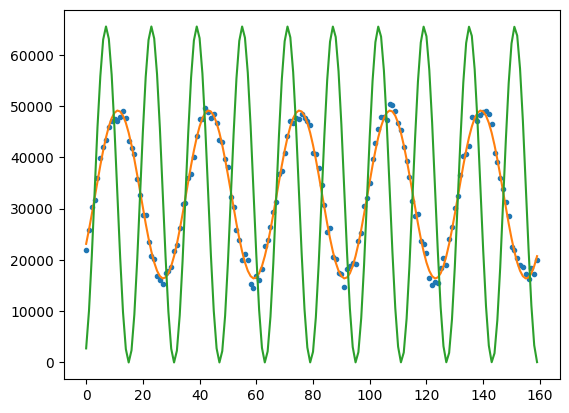

In [4]:
length = 1024* 32

n = np.arange(length)

noise = np.int16((np.random.random(length) - 0.5) * (2**12))

input0 = np.uint16(np.sin(2 * np.pi * n / 32 + (0.8 * np.pi)) * ((2**14) - 1) + (2**15))

input = input0 + noise

lut   = np.uint16((-1 * np.sin(np.linspace(0, 1, 2**14) * 2 * np.pi))  * ((2**15) - 1) + (2**15))

pll = pll_gen()

output = np.zeros(length, dtype=np.uint16)

for i in range(length):
  output[i] = pll(input[i])

output_wave = list(map(lambda idx: lut[idx], output))

plt.plot(input[160:320], marker="o", markersize = 3, linestyle='None')
plt.plot(input0[160:320])
plt.plot(output_wave[160:320])

plt.figure()
plt.plot(input[10000:10160], marker="o", markersize = 3, linestyle='None')
plt.plot(input0[10000:10160])
plt.plot(output_wave[10000:10160])


(0.0, 65535.0, 32768.0)

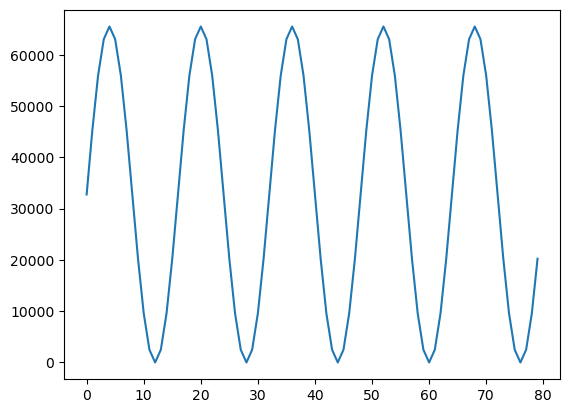

In [6]:
lut_data = np.uint16((-1 * (np.sin(np.linspace(0, 1, 2**12) * np.pi/2)) + 1) * 32767)

def lut_lookup(index: np.uint16) -> np.uint16:
    '''index: np.uint16: lower 14 bits effective
    '''
    index = index & (2**14 - 1)
    sign1 = (index & 2**13) >> 13
    sign2 = (index & 2**12) >> 12
    step  = index & (2**12 - 1)
    step = ((2**12-1)- step) if sign2 == 1 else step
    data = (65535 - lut_data[step]) if sign1 == 0 else lut_data[step]
    
    return data

nco2 = nco_gen()

trace_sig = np.zeros(80)

for i in range(80):
    trace_sig[i] = lut_lookup(nco2(2**20))

plt.plot(trace_sig)
min(trace_sig), max(trace_sig), trace_sig[0]

In [5]:
lut.terminate()

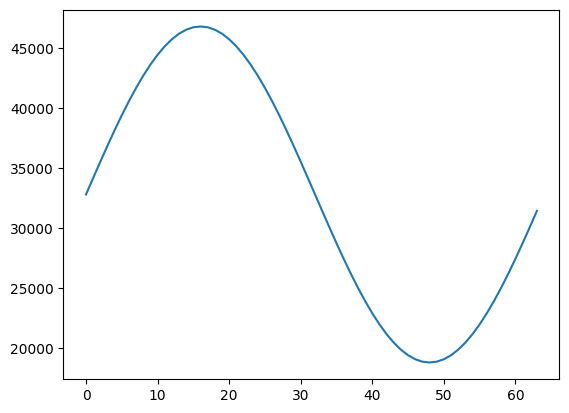

In [16]:
from lut import LUT
lut_data = np.uint16((-14000 * (np.sin(np.linspace(0, 1, 2**12) * np.pi/2)) + 32767))

lut = LUT("../../build/exec/lut", lut_data, silent=True)
nco2 = nco_gen()

trace_sig = np.zeros(80)

for i in range(80):
    trace_sig[i] = lut.forward(nco2(2**18))

plt.plot(trace_sig[:64])
min(trace_sig), max(trace_sig), trace_sig[0]

lut.terminate()

In [17]:
with open("lut_data.coe", "w") as f:
    f.write("memory_initialization_radix=10;\n")
    f.write("memory_initialization_vector=\n")
    for i in range(len(lut_data)):
        f.write("{}{}".format(lut_data[i], "," if i < len(lut_data)-1 else ";"))
        f.write("\n")

In [18]:
1 << 16

65536